# Simulation using Concord

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import Concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
proj_name = "simulation_cluster_singlebatch"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = f"../data/{proj_name}/"
data_dir = Path(data_dir)
data_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 0
ccd.ul.set_seed(seed)

file_suffix = f"{time.strftime('%b%d-%H%M')}"
file_suffix

cpu


'Feb06-1205'

In [4]:
state_key = 'cluster'
batch_key = 'batch'
state_type = 'cluster'
leiden_key='leiden'
batch_type = 'batch_specific_features'
distribution = 'normal'
n_cells = [200,100,100,50,30]
n_genes = [100,100,50,30,20]
state_dispersion = [5.0,4.0,4.0,3.0,2.0]

In [5]:
from Concord.utils.simulation import Simulation

sim = Simulation(n_cells=n_cells, n_genes=n_genes,
                 n_batches=1, n_states=5, 
                 state_type=state_type, 
                 state_distribution = distribution, 
                 state_level=5, 
                 state_min_level=0,
                 state_dispersion=[5.0,4.0,4.0,3.0,2.0], 
                 program_structure="uniform",
                 program_on_time_fraction=0.3,
                 trajectory_program_num=4,
                 trajectory_loop_to=[1],
                 batch_feature_frac=0.15,
                 batch_distribution = distribution,
                 batch_type=batch_type, 
                 batch_level=[5,5], 
                 batch_dispersion=[3.0, 3.0], 
                 global_non_specific_gene_fraction=0.1,
                 pairwise_non_specific_gene_fraction={
                     (0,1):0.7, (0,2):0.0, (0,3):0.0, (0,4):0.0, 
                     (1,2):0.0, (1,3):0.0, (1,4):0.0, 
                     (2,3):0.4, (2,4):0.0,
                     (3,4):0.0
                 },
                 non_neg=True, to_int=True,
                 seed=seed)

# Generate the simulated data
adata, adata_state = sim.simulate_data()

Concord.utils.simulation - INFO - Simulating 5 clusters with distribution: normal with mean expression 5 and dispersion [5.0, 4.0, 4.0, 3.0, 2.0].
Concord.utils.simulation - INFO - Adding non-specific genes to the expression matrix. Note this will increase gene count compared to the specified value.
Concord.utils.simulation - INFO - Adding non-specific genes to the expression matrix. Note this will increase gene count compared to the specified value.
Concord.utils.simulation - INFO - Simulating batch-specific features effect on batch_1 by appending a set of batch-specific genes with normal distributed value with level 5 and dispersion 3.0.


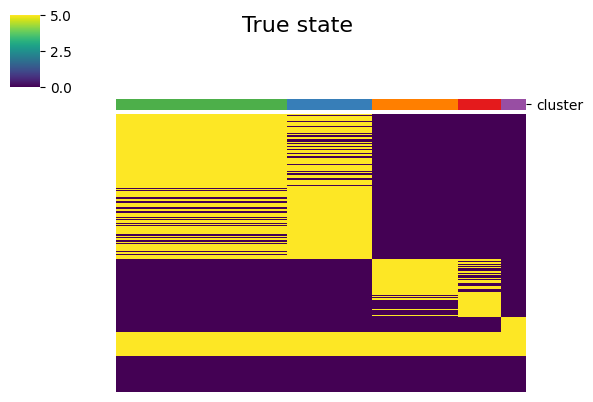

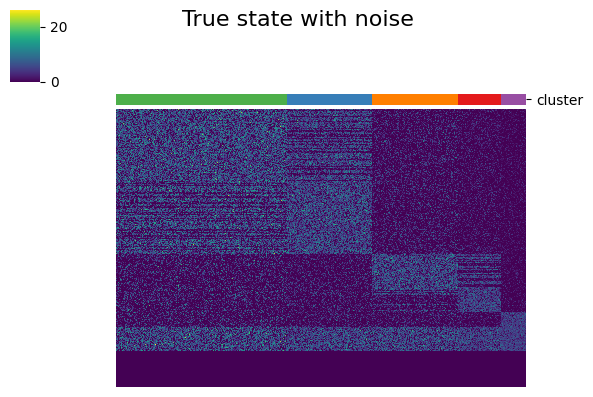

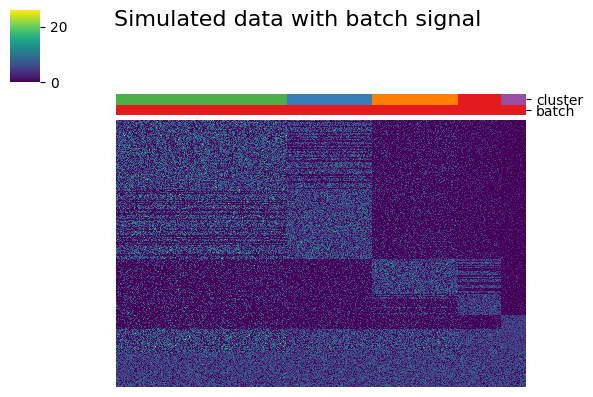

In [6]:
ccd.pl.heatmap_with_annotations(adata, val='no_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state', save_path=save_dir/f'true_state_heatmap_{file_suffix}.svg', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata, val='wt_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state with noise', save_path=save_dir/f'true_state_with_noise_heatmap_{file_suffix}.svg', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, batch_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Simulated data with batch signal', save_path=save_dir/f'simulated_data_heatmap_{file_suffix}.svg', figsize=(6, 4), dpi=300)

In [7]:
adata.shape

(480, 345)

### No batch effect, no noise

In [8]:
n_components = 15
ccd.ul.run_pca(adata, source_key='no_noise', result_key='PCA_no_noise', n_pc=n_components, random_state=seed)
ccd.ul.run_umap(adata, source_key='no_noise', result_key='UMAP_no_noise', random_state=seed)
sc.pp.neighbors(adata, use_rep='PCA_no_noise', n_neighbors=30, random_state=seed)
sc.tl.leiden(adata, resolution=1.0, key_added=leiden_key, random_state=seed)
#adata.obs[leiden_key] = adata_state.obs[leiden_key]

Concord - INFO - PCA performed on source data with 15 components
Concord - INFO - PCA embedding stored in adata.obsm['PCA_no_noise']
Concord - INFO - UMAP embedding stored in adata.obsm['UMAP_no_noise']


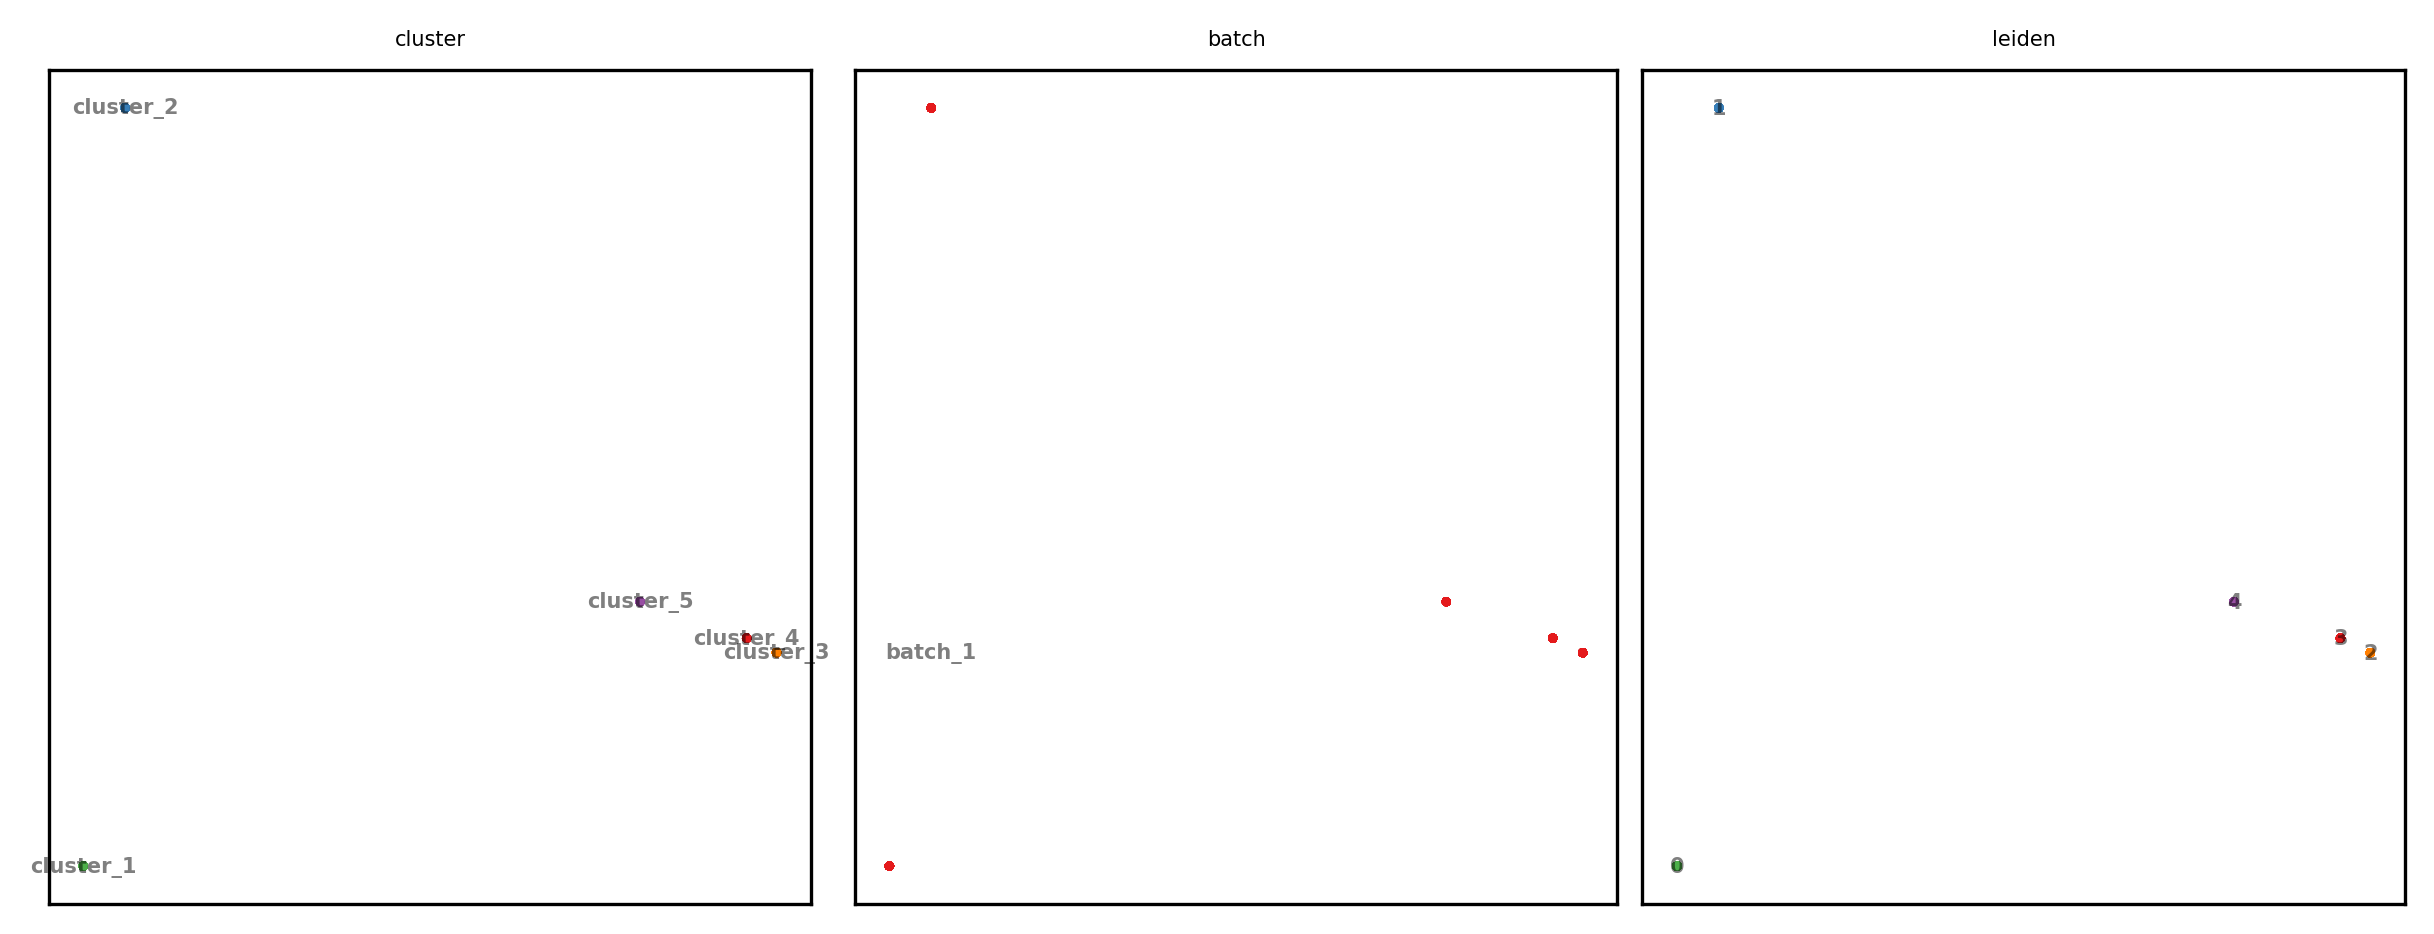

In [9]:
show_basis = 'PCA_no_noise'
show_cols = [state_key, batch_key, leiden_key]

ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"nobatch_{show_basis}_{file_suffix}.svg"
)

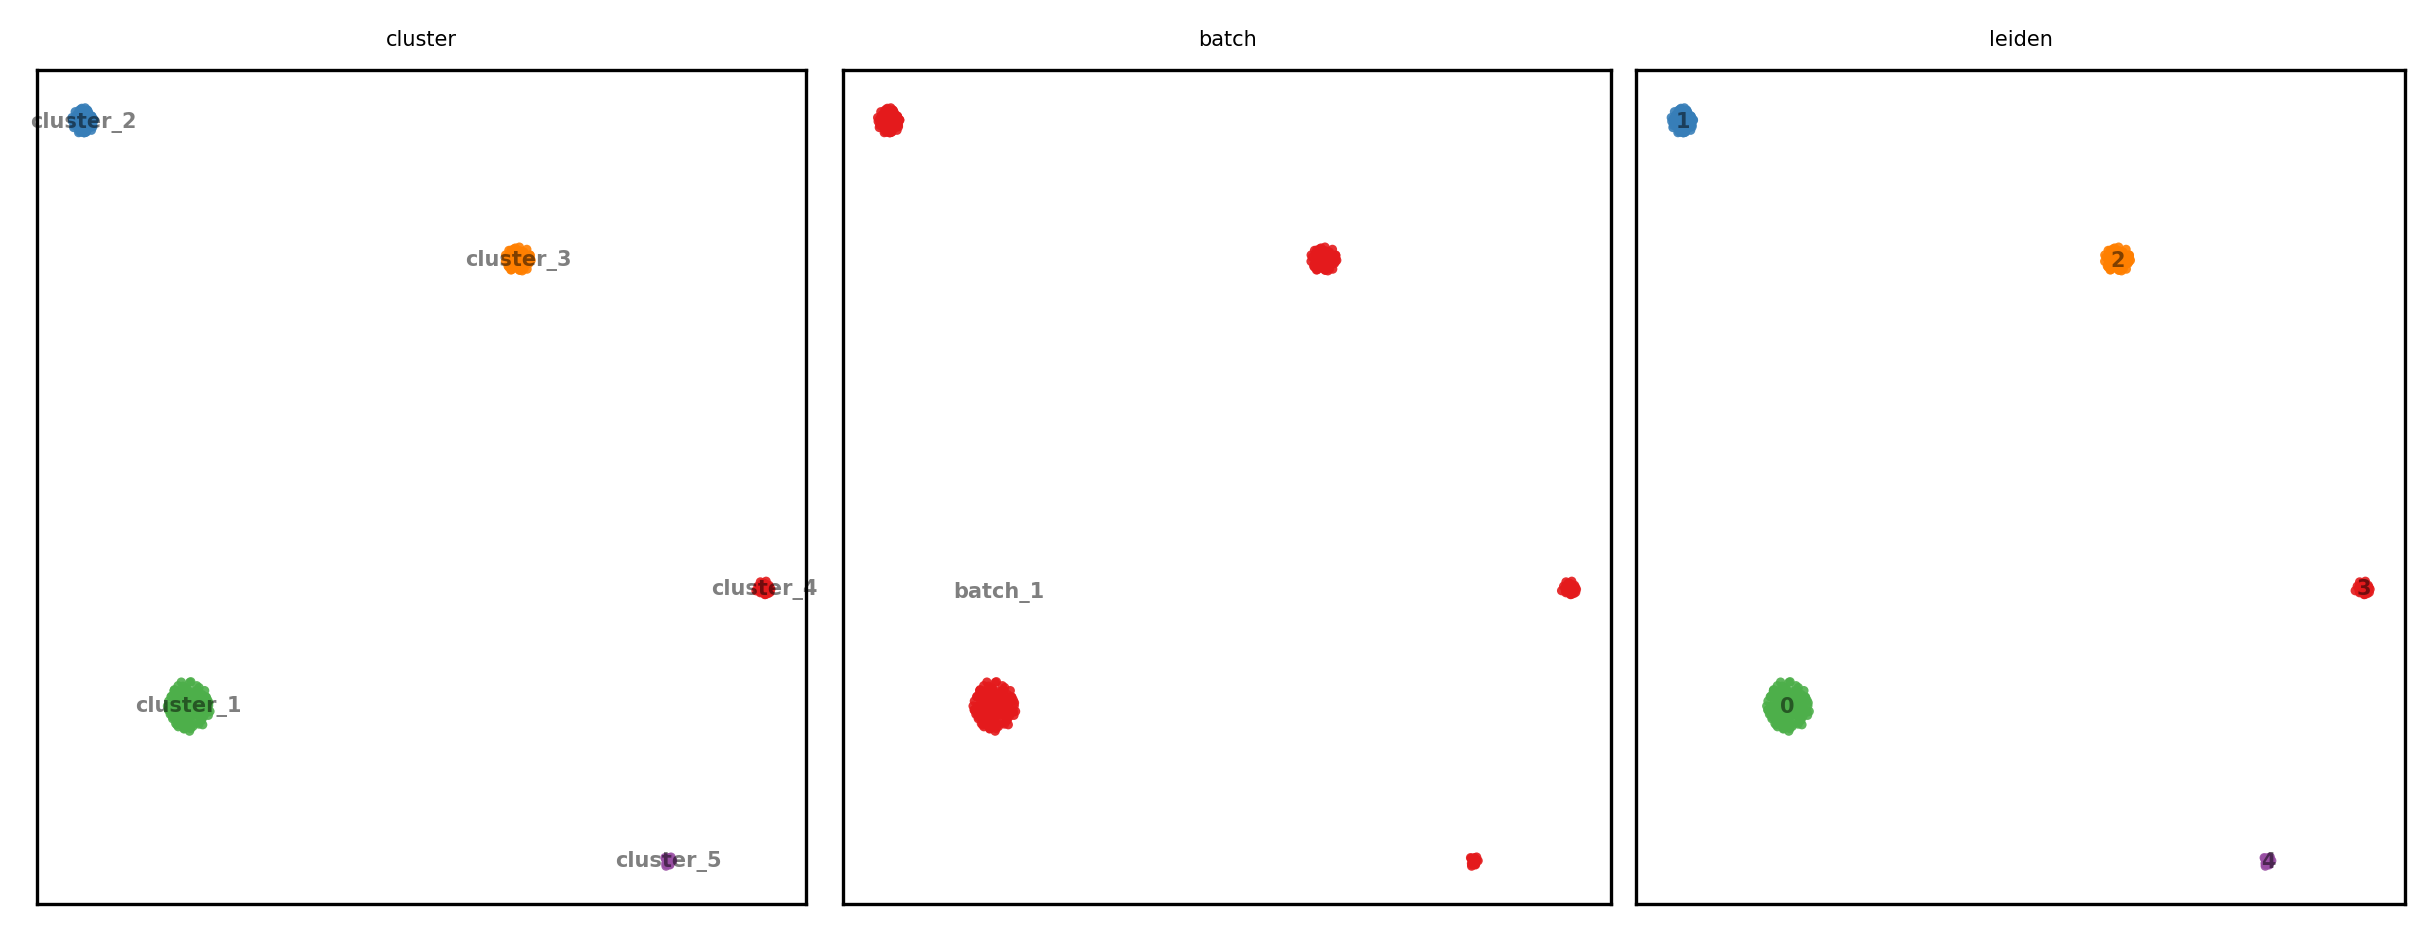

In [10]:
show_basis = 'UMAP_no_noise'

ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"nobatch_{show_basis}_{file_suffix}.svg"
)

### noise added, Run all methods

In [7]:
run_methods = ["PCA", "UMAP", "t-SNE", "DiffusionMap", "NMF", 
             "FactorAnalysis", "FastICA", "LDA", "ZIFA", "scVI", "PHATE", 
             "Concord", "Concord-decoder", "Concord-pknn0"]
# exclude ["UMAP", "t-SNE"] from run_method, and save as combined_keys
exclude_keys = ["PCA", "UMAP", "t-SNE"]
combined_keys = ['no_noise', 'wt_noise'] + [key for key in run_methods if key not in exclude_keys]
combined_keys

['no_noise',
 'wt_noise',
 'DiffusionMap',
 'NMF',
 'FactorAnalysis',
 'FastICA',
 'LDA',
 'ZIFA',
 'scVI',
 'PHATE',
 'Concord',
 'Concord-decoder',
 'Concord-pknn0']

In [18]:
adata.shape

(480, 345)

In [9]:
time_log = ccd.ul.run_dimensionality_reduction_pipeline(
    adata,
    source_key="X",
    methods=[ "Concord", "Concord-decoder", "Concord-pknn0"],
    n_components=30,
    random_state=seed,
    device=device,
    save_dir=save_dir,
    concord_epochs=15,
    concord_min_pid=0.95
)

Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.


Concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.
Concord - WARNING - p_intra_knn * batch_size (12) is greater than sampler_knn (9). This will cause actual sampling ratio not matching specified p_intra_knn.
Concord - WARNING - You should either set batch_size to be smaller than sampler_knn/p_intra_knn (45)
Concord - WARNING - or set sampler_knn to be greater than p_intra_knn * batch_size (12).
Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.
Concord.model.dataloader - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
p_intra_knn: 0


Epoch 0 Training: 7it [00:00, 342.84it/s, loss=4.31]
Epoch 14 Training: 100%|██████████| 7/7 [00:00<00:00, 440.66it/s, loss=3.75]


Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.
Concord - WARNING - p_intra_knn * batch_size (12) is greater than sampler_knn (9). This will cause actual sampling ratio not matching specified p_intra_knn.
Concord - WARNING - You should either set batch_size to be smaller than sampler_knn/p_intra_knn (45)
Concord - WARNING - or set sampler_knn to be greater than p_intra_knn * batch_size (12).
Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.
Concord.model.dataloader - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
p_intra_knn: 0


Epoch 0 Training: 7it [00:00, 356.23it/s, loss=17.1]
Epoch 14 Training: 100%|██████████| 7/7 [00:00<00:00, 415.90it/s, loss=13.3]


Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.
Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.
Concord.model.dataloader - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
p_intra_knn: 0.0


Epoch 0 Training: 7it [00:00, 485.13it/s, loss=4.31]
Epoch 14 Training: 100%|██████████| 7/7 [00:00<00:00, 411.86it/s, loss=3.75]


In [10]:
# Run umap and PCA for all latent embeddings
adata.obsm['no_noise'] = adata.layers['no_noise']
adata.obsm['wt_noise'] = adata.layers['wt_noise']
max_pc = 15
for basis in combined_keys:
    print("Running UMAP and PCA for", basis)
    #if 'UMAP' not in basis:
    ccd.ul.run_umap(adata, source_key=basis, result_key=f'{basis}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)
    if not any(substring in basis for substring in ['PHATE', 'PCA']):
        if basis in adata.layers.keys():
            n_pc = min(min(adata.layers[basis].shape[1], adata.shape[0]) - 1, max_pc)
        else:
            n_pc = min(min(adata.obsm[basis].shape[1], adata.shape[0]) - 1, max_pc)
        
        print("n_pc", n_pc)
        ccd.ul.run_pca(adata, source_key=basis, result_key=f'{basis}_PCA', n_pc=n_pc, random_state=seed)


Running UMAP and PCA for no_noise


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


n_pc 15
Running UMAP and PCA for wt_noise
n_pc 15
Running UMAP and PCA for DiffusionMap
n_pc 14
Running UMAP and PCA for NMF
n_pc 14
Running UMAP and PCA for FactorAnalysis
n_pc 14
Running UMAP and PCA for FastICA
n_pc 14
Running UMAP and PCA for LDA
n_pc 14
Running UMAP and PCA for ZIFA
n_pc 14
Running UMAP and PCA for scVI
n_pc 15
Running UMAP and PCA for PHATE
Running UMAP and PCA for Concord
n_pc 15
Running UMAP and PCA for Concord-decoder
n_pc 15
Running UMAP and PCA for Concord-pknn0
n_pc 15


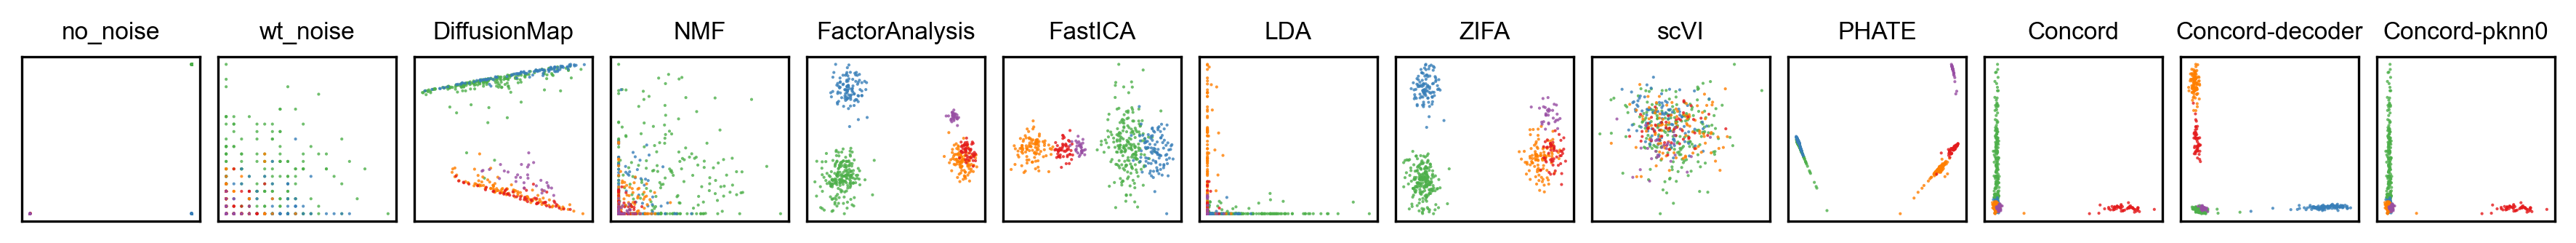

Concord.plotting.pl_embedding - ERROR - Error plotting PAGA for no_noise: mismatching number of index arrays for shape; got 0, expected 2


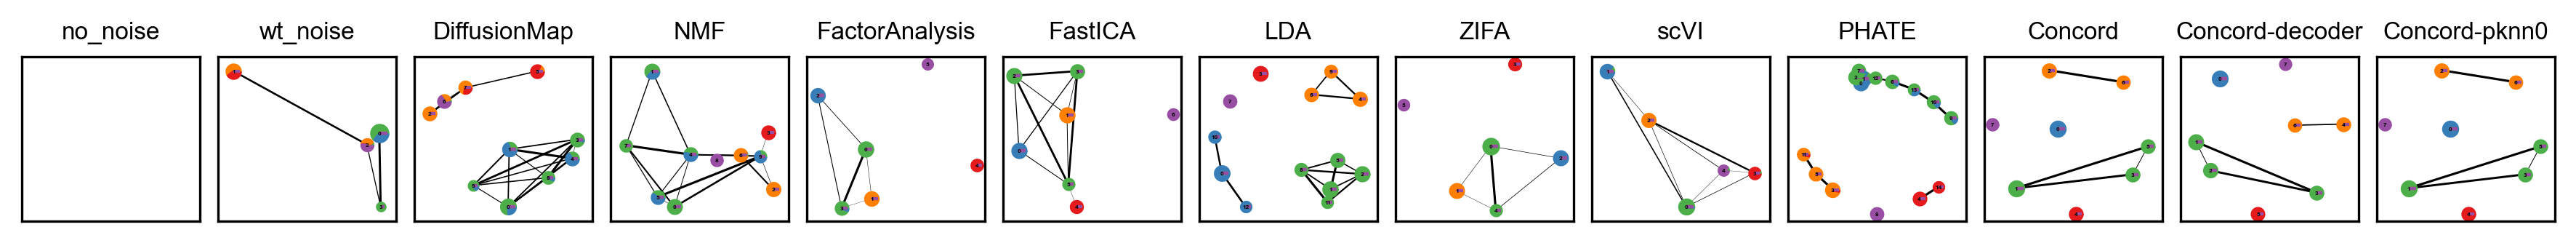

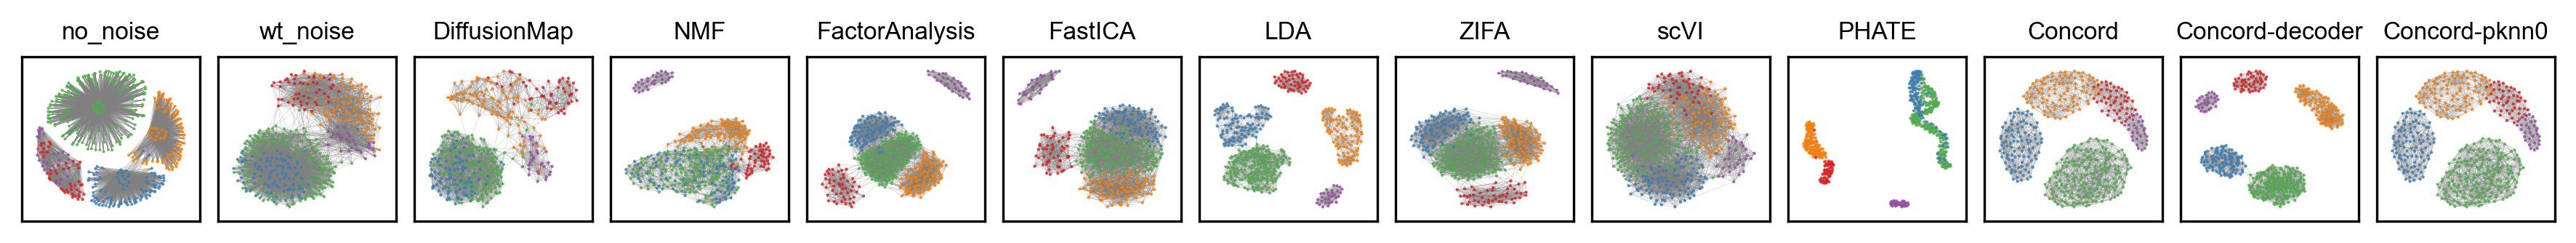

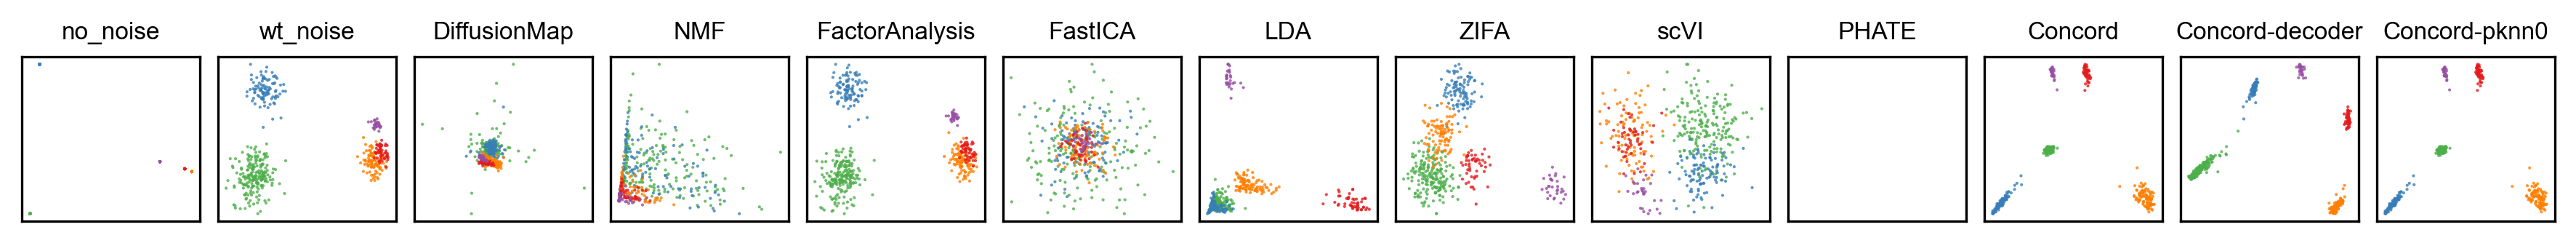

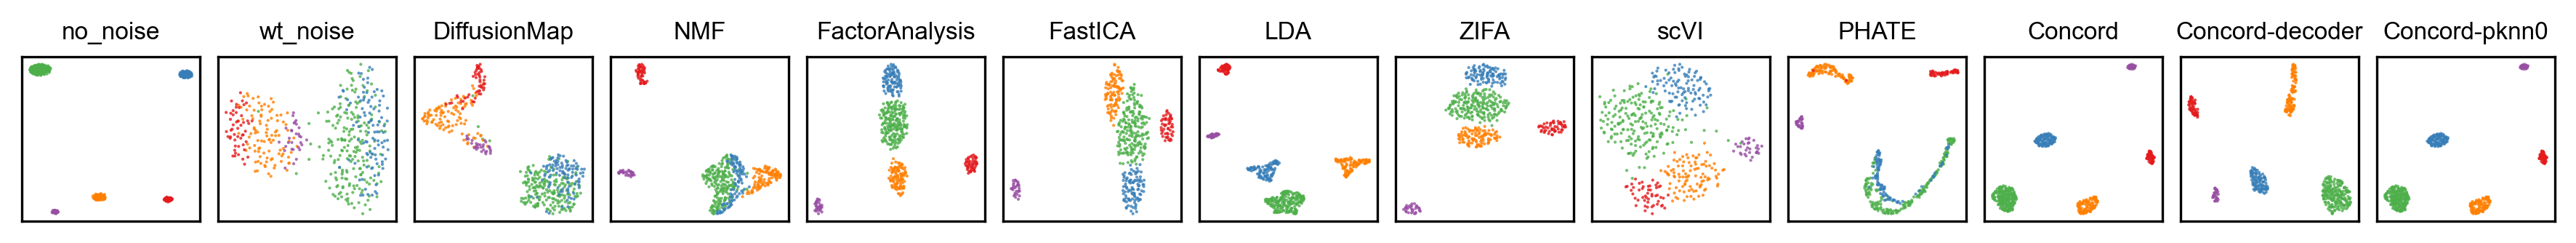

In [14]:
# plot everything
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import font_manager, rcParams

# Set Arial as the default font
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

color_bys = [state_key]
basis_types = ['', 'PAGA', 'KNN', 'PCA', 'UMAP']

font_size=8
point_size=4
alpha=0.8
figsize=(0.9*len(combined_keys),1)
ncols = len(combined_keys)
nrows = 1
pal = {'state':'tab10'}
k=15
edges_color='grey'
edges_width=0.05
layout='kk'
threshold = 0.1
node_size_scale=0.1
edge_width_scale=0.1

with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        combined_keys,
        color_bys=color_bys,
        basis_types=basis_types,
        pal=pal,
        k=k,
        edges_color=edges_color,
        edges_width=edges_width,
        layout=layout,
        threshold=threshold,
        node_size_scale=node_size_scale,
        edge_width_scale=edge_width_scale,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        ncols=ncols,
        seed=1,
        leiden_key='leiden',
        save_dir=save_dir,
        file_suffix=file_suffix,
        save_format='svg'
    )


In [15]:
# sort and smooth the signal along the path
batch_id=adata.obs['batch'].unique()[0]
batch_indices = np.where(adata.obs['batch'] == batch_id)[0]
_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='Concord', path=batch_indices, sigma=2)
adata.obsm['Concord_sorted'] = adata.obsm['Concord'][:, feature_order]

_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='Concord-decoder', path=batch_indices, sigma=2)
adata.obsm['Concord-decoder_sorted'] = adata.obsm['Concord-decoder'][:, feature_order]

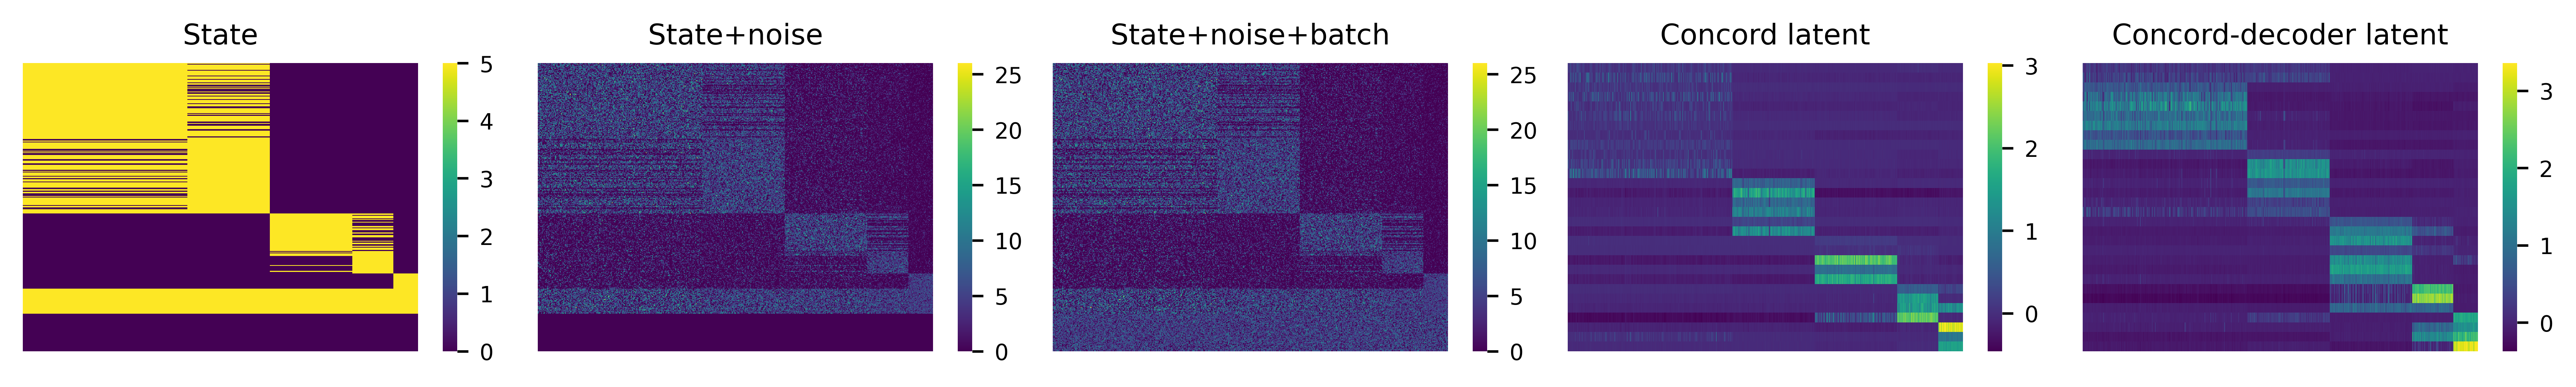

In [16]:
# Plot heatmap of original data and Concord latent
import matplotlib.pyplot as plt
figsize = (2.3, 1.8)
ncols = 5
title_fontsize = 9
dpi = 600
fig, axes = plt.subplots(1, ncols, figsize=(figsize[0] * ncols, figsize[1]), dpi=dpi)
ccd.pl.heatmap_with_annotations(adata, val='no_noise', obs_keys=[state_key], ax = axes[0], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='wt_noise', obs_keys=[state_key], ax = axes[1], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, batch_key], ax = axes[2], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise+batch', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='Concord_sorted', obs_keys=[state_key, batch_key], ax = axes[3], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord latent', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='Concord-decoder_sorted', obs_keys=[state_key, batch_key], ax = axes[4], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord-decoder latent', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
plt.tight_layout(w_pad=0.0, h_pad=0.1)
plt.savefig(save_dir / f"all_heatmaps_{file_suffix}.svg", dpi=dpi, bbox_inches='tight')

In [17]:
adata.write_h5ad(data_dir / f"adata_{file_suffix}.h5ad")
adata_state.write_h5ad(data_dir / f"adata_state_{file_suffix}.h5ad")
file_suffix

'Feb06-1205'

# Evaluation

In [ ]:
# adata = sc.read(data_dir / f"adata_Dec14-1846.h5ad")
# adata_state = sc.read(data_dir / f"adata_state_Dec14-1846.h5ad")
adata = sc.read(data_dir / f"adata_Feb06-1205.h5ad")
adata_state = sc.read(data_dir / f"adata_state_Feb06-1205.h5ad")

### Topology

Run topological analysis pipeline:

In [23]:
run_methods = ["PCA", "UMAP", "t-SNE", "DiffusionMap", "NMF", 
             "FactorAnalysis", "FastICA", "LDA", "ZIFA", "scVI", "PHATE", 
             "Concord", "Concord-decoder"]
# exclude ["UMAP", "t-SNE"] from run_method, and save as combined_keys
exclude_keys = ["PCA", "UMAP", "t-SNE"]
combined_keys = ['no_noise_PCA', 'wt_noise_PCA'] + [key for key in run_methods if key not in exclude_keys]
combined_keys

['no_noise_PCA',
 'wt_noise_PCA',
 'DiffusionMap',
 'NMF',
 'FactorAnalysis',
 'FastICA',
 'LDA',
 'ZIFA',
 'scVI',
 'PHATE',
 'Concord',
 'Concord-decoder']

In [24]:
homology_dimensions = [0,1,2]
diagrams = {}
for key in combined_keys:
    print(f"Computing persistent homology for {key}")
    diagrams[key] =  ccd.ul.compute_persistent_homology(adata, key=key, homology_dimensions=homology_dimensions)

import pickle
with open(save_dir / f"topology_diagrams_{file_suffix}.pkl", 'wb') as f:
    pickle.dump(diagrams, f)

Computing persistent homology for no_noise_PCA
Computing persistent homology for wt_noise_PCA
Computing persistent homology for DiffusionMap
Computing persistent homology for NMF
Computing persistent homology for FactorAnalysis
Computing persistent homology for FastICA
Computing persistent homology for LDA
Computing persistent homology for ZIFA
Computing persistent homology for scVI
Computing persistent homology for PHATE
Computing persistent homology for Concord
Computing persistent homology for Concord-decoder


In [25]:
save_dir / f"topology_diagrams_{file_suffix}.pkl"

PosixPath('../save/dev_simulation_cluster_singlebatch-Dec14/topology_diagrams_Dec14-1846.pkl')

In [ ]:
import pickle
with open(Path(PosixPath('../save/dev_simulation_cluster_singlebatch-Dec14/topology_diagrams_Dec14-1846.pkl')), 'rb') as f:
    diagrams = pickle.load(f)

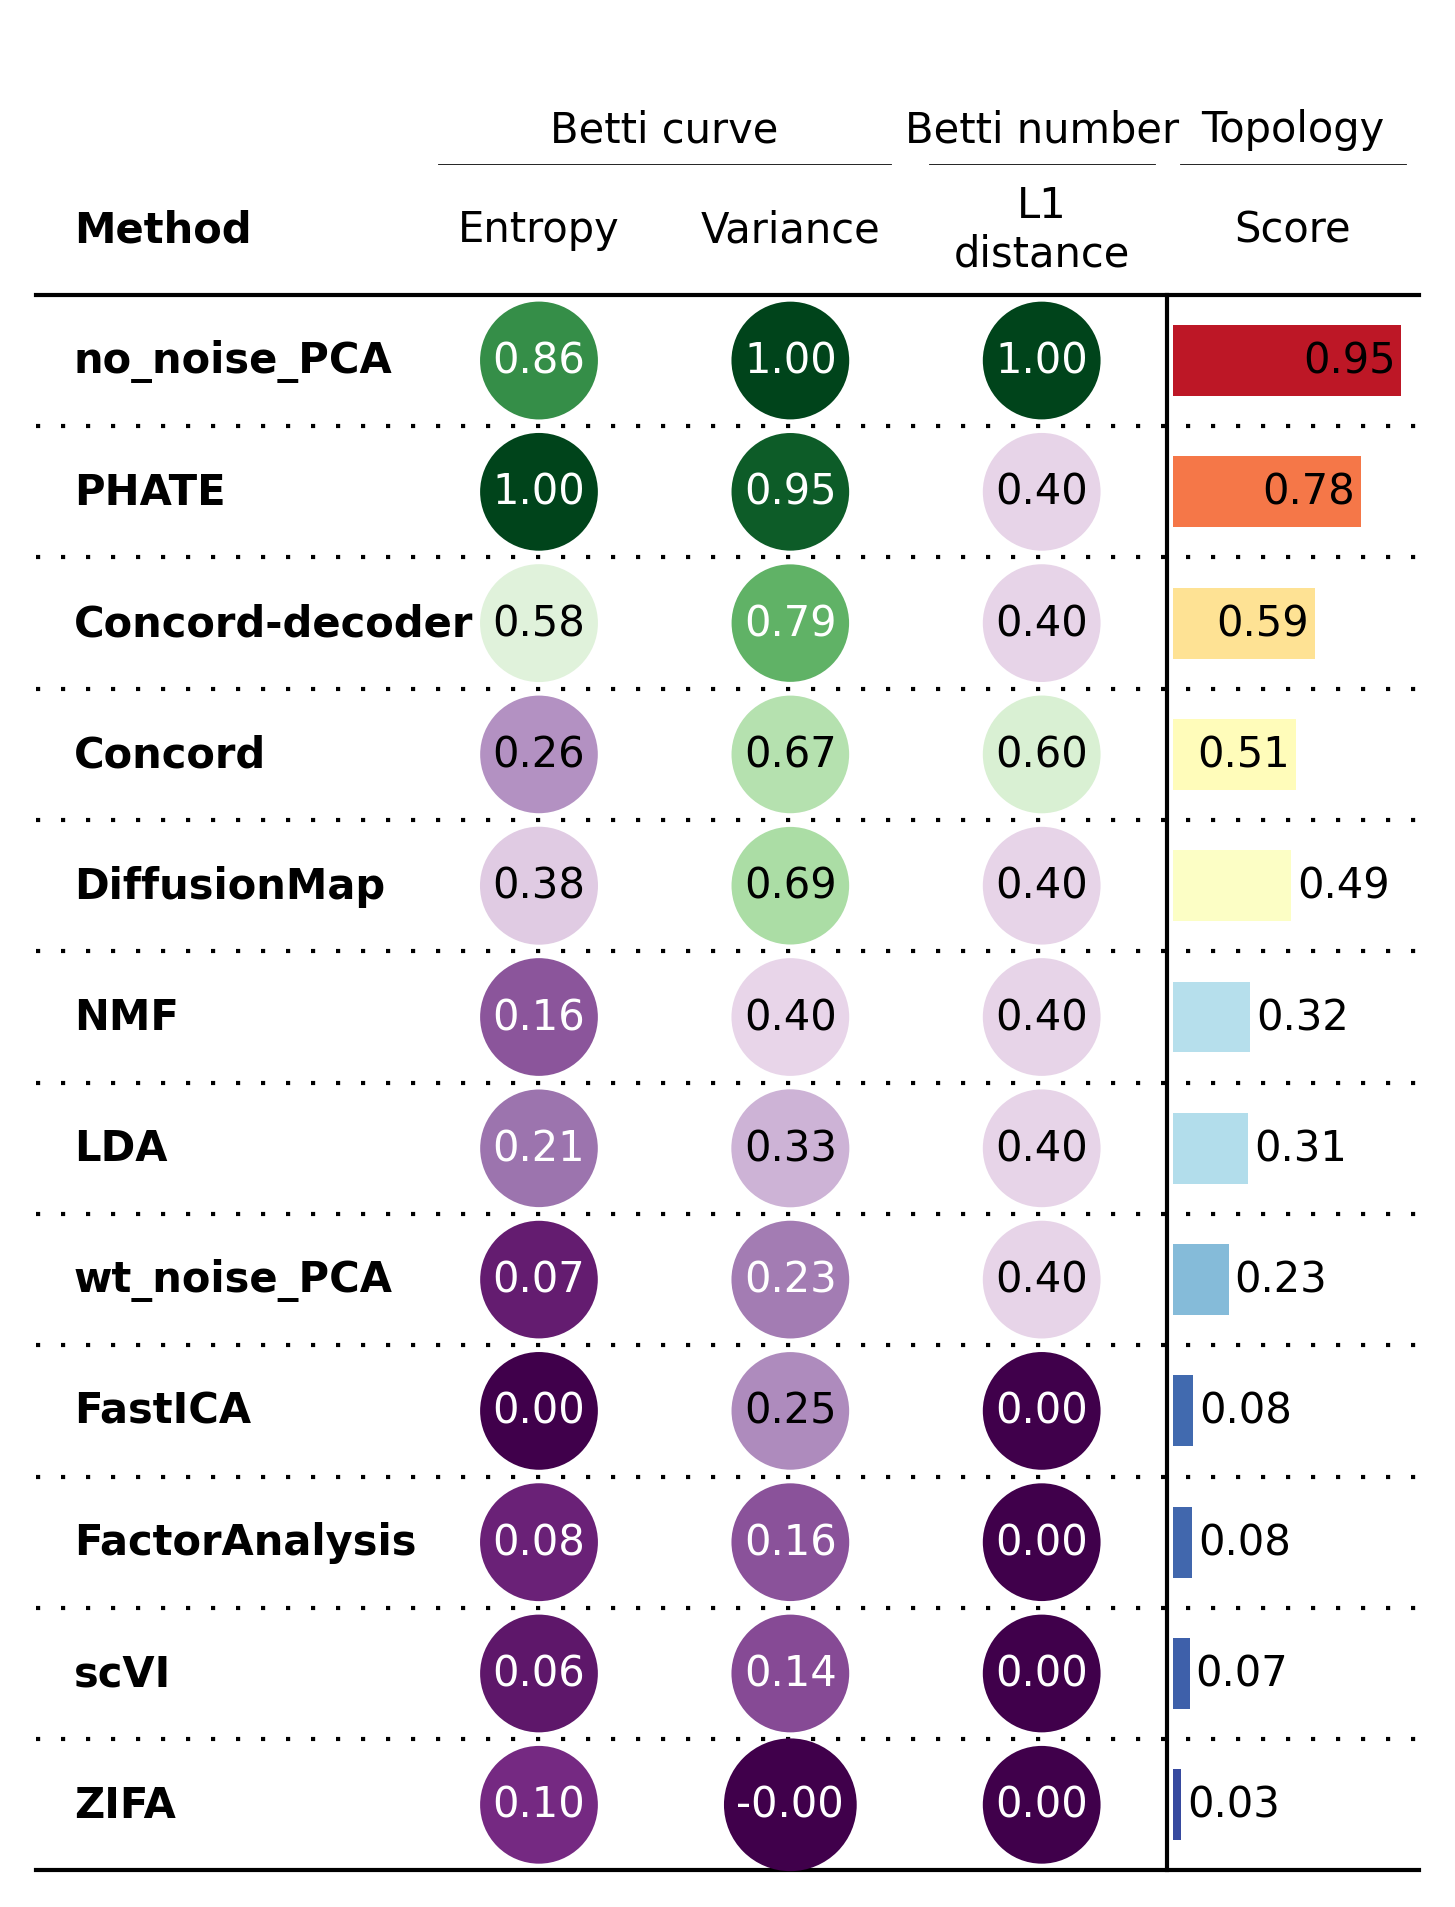

In [26]:
topology_results = ccd.ul.benchmark_topology(diagrams, expected_betti_numbers=[4,0,0], save_dir=save_dir, file_suffix=file_suffix)
max_betti = 5
topology_metrics = topology_results['combined_metrics']#.drop(index=['no_noise_PCA', 'wt_noise_PCA'])
topology_metrics[('Betti number', 'L1 distance')] = topology_metrics[('Betti number', 'L1 distance')].clip(upper=5)
agg_name1 = 'Topology'
agg_name2 = 'Score'
topology_scores = ccd.ul.benchmark_stats_to_score(topology_metrics, min_max_scale=True, one_minus=True, aggregate_score=True, aggregate_score_name1=agg_name1, aggregate_score_name2=agg_name2, rank=True, rank_col=(agg_name1,agg_name2), name_exact=False)
ccd.pl.plot_benchmark_table(topology_scores, pal='PRGn', pal_agg='RdYlBu_r', cmap_method = 'minmax', agg_name = agg_name1, save_path=save_dir / f"topology_results_{file_suffix}.pdf", figsize=(6, 8), dpi=300)

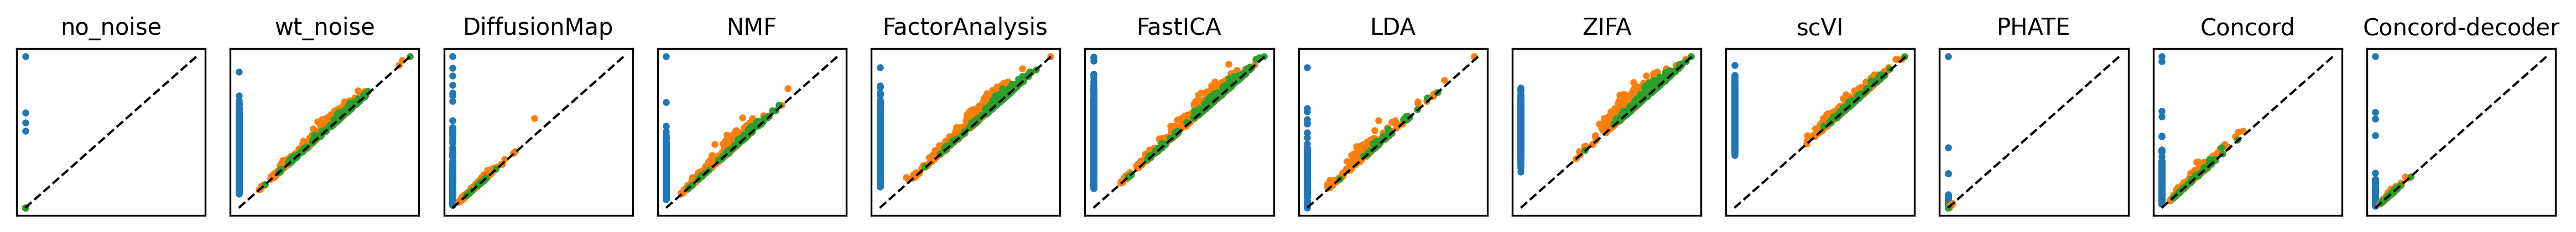

In [27]:
# Reorder diagrams with the same order as the combined keys
diagrams_ordered = {key: diagrams[key] for key in combined_keys}
# Change the key names to remove 'PCA_'
diagrams_ordered = {key.replace('_PCA', ''): diagrams_ordered[key] for key in diagrams_ordered}
ccd.pl.plot_persistence_diagrams(diagrams_ordered, base_size=(1.3, 1.5), dpi=300, marker_size=4, n_cols=12, fontsize=10, save_path=save_dir / f"persistence_diagrams_{file_suffix}.pdf", legend=False, label_axes=False, axis_ticks=False)

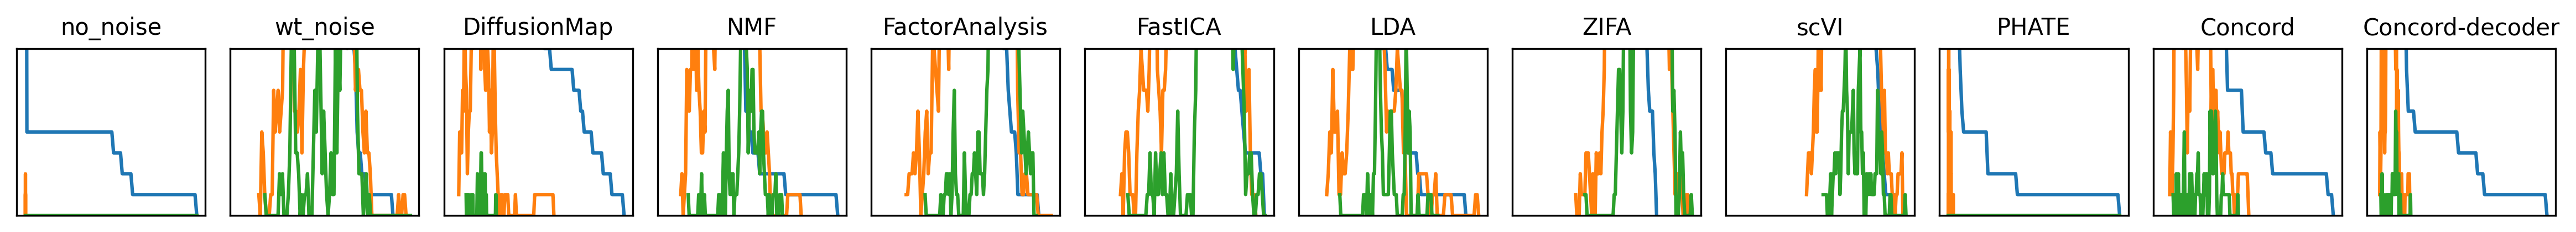

In [28]:
ccd.pl.plot_betti_curves(diagrams_ordered, nbins=100, base_size=(1.3, 1.5), n_cols=12, fontsize=10, save_path=save_dir / f"betti_curves_{file_suffix}.pdf", dpi=300, legend=False, label_axes=False, axis_ticks=False)

Concord.model.knn - WARNING - Mask inconsistency: more than expected neighbors found in one or more rows.
Concord.model.knn - WARNING - Mask inconsistency: more than expected neighbors found in one or more rows.
Concord.model.knn - WARNING - Mask inconsistency: more than expected neighbors found in one or more rows.
Concord.model.knn - WARNING - Mask inconsistency: more than expected neighbors found in one or more rows.
Concord.model.knn - WARNING - Mask inconsistency: more than expected neighbors found in one or more rows.
Concord.model.knn - WARNING - Mask inconsistency: more than expected neighbors found in one or more rows.
Concord.model.knn - WARNING - Mask inconsistency: more than expected neighbors found in one or more rows.
Concord.model.knn - WARNING - Mask inconsistency: more than expected neighbors found in one or more rows.
Concord.model.knn - WARNING - Mask inconsistency: more than expected neighbors found in one or more rows.
Concord.model.knn - WARNING - Mask inconsisten

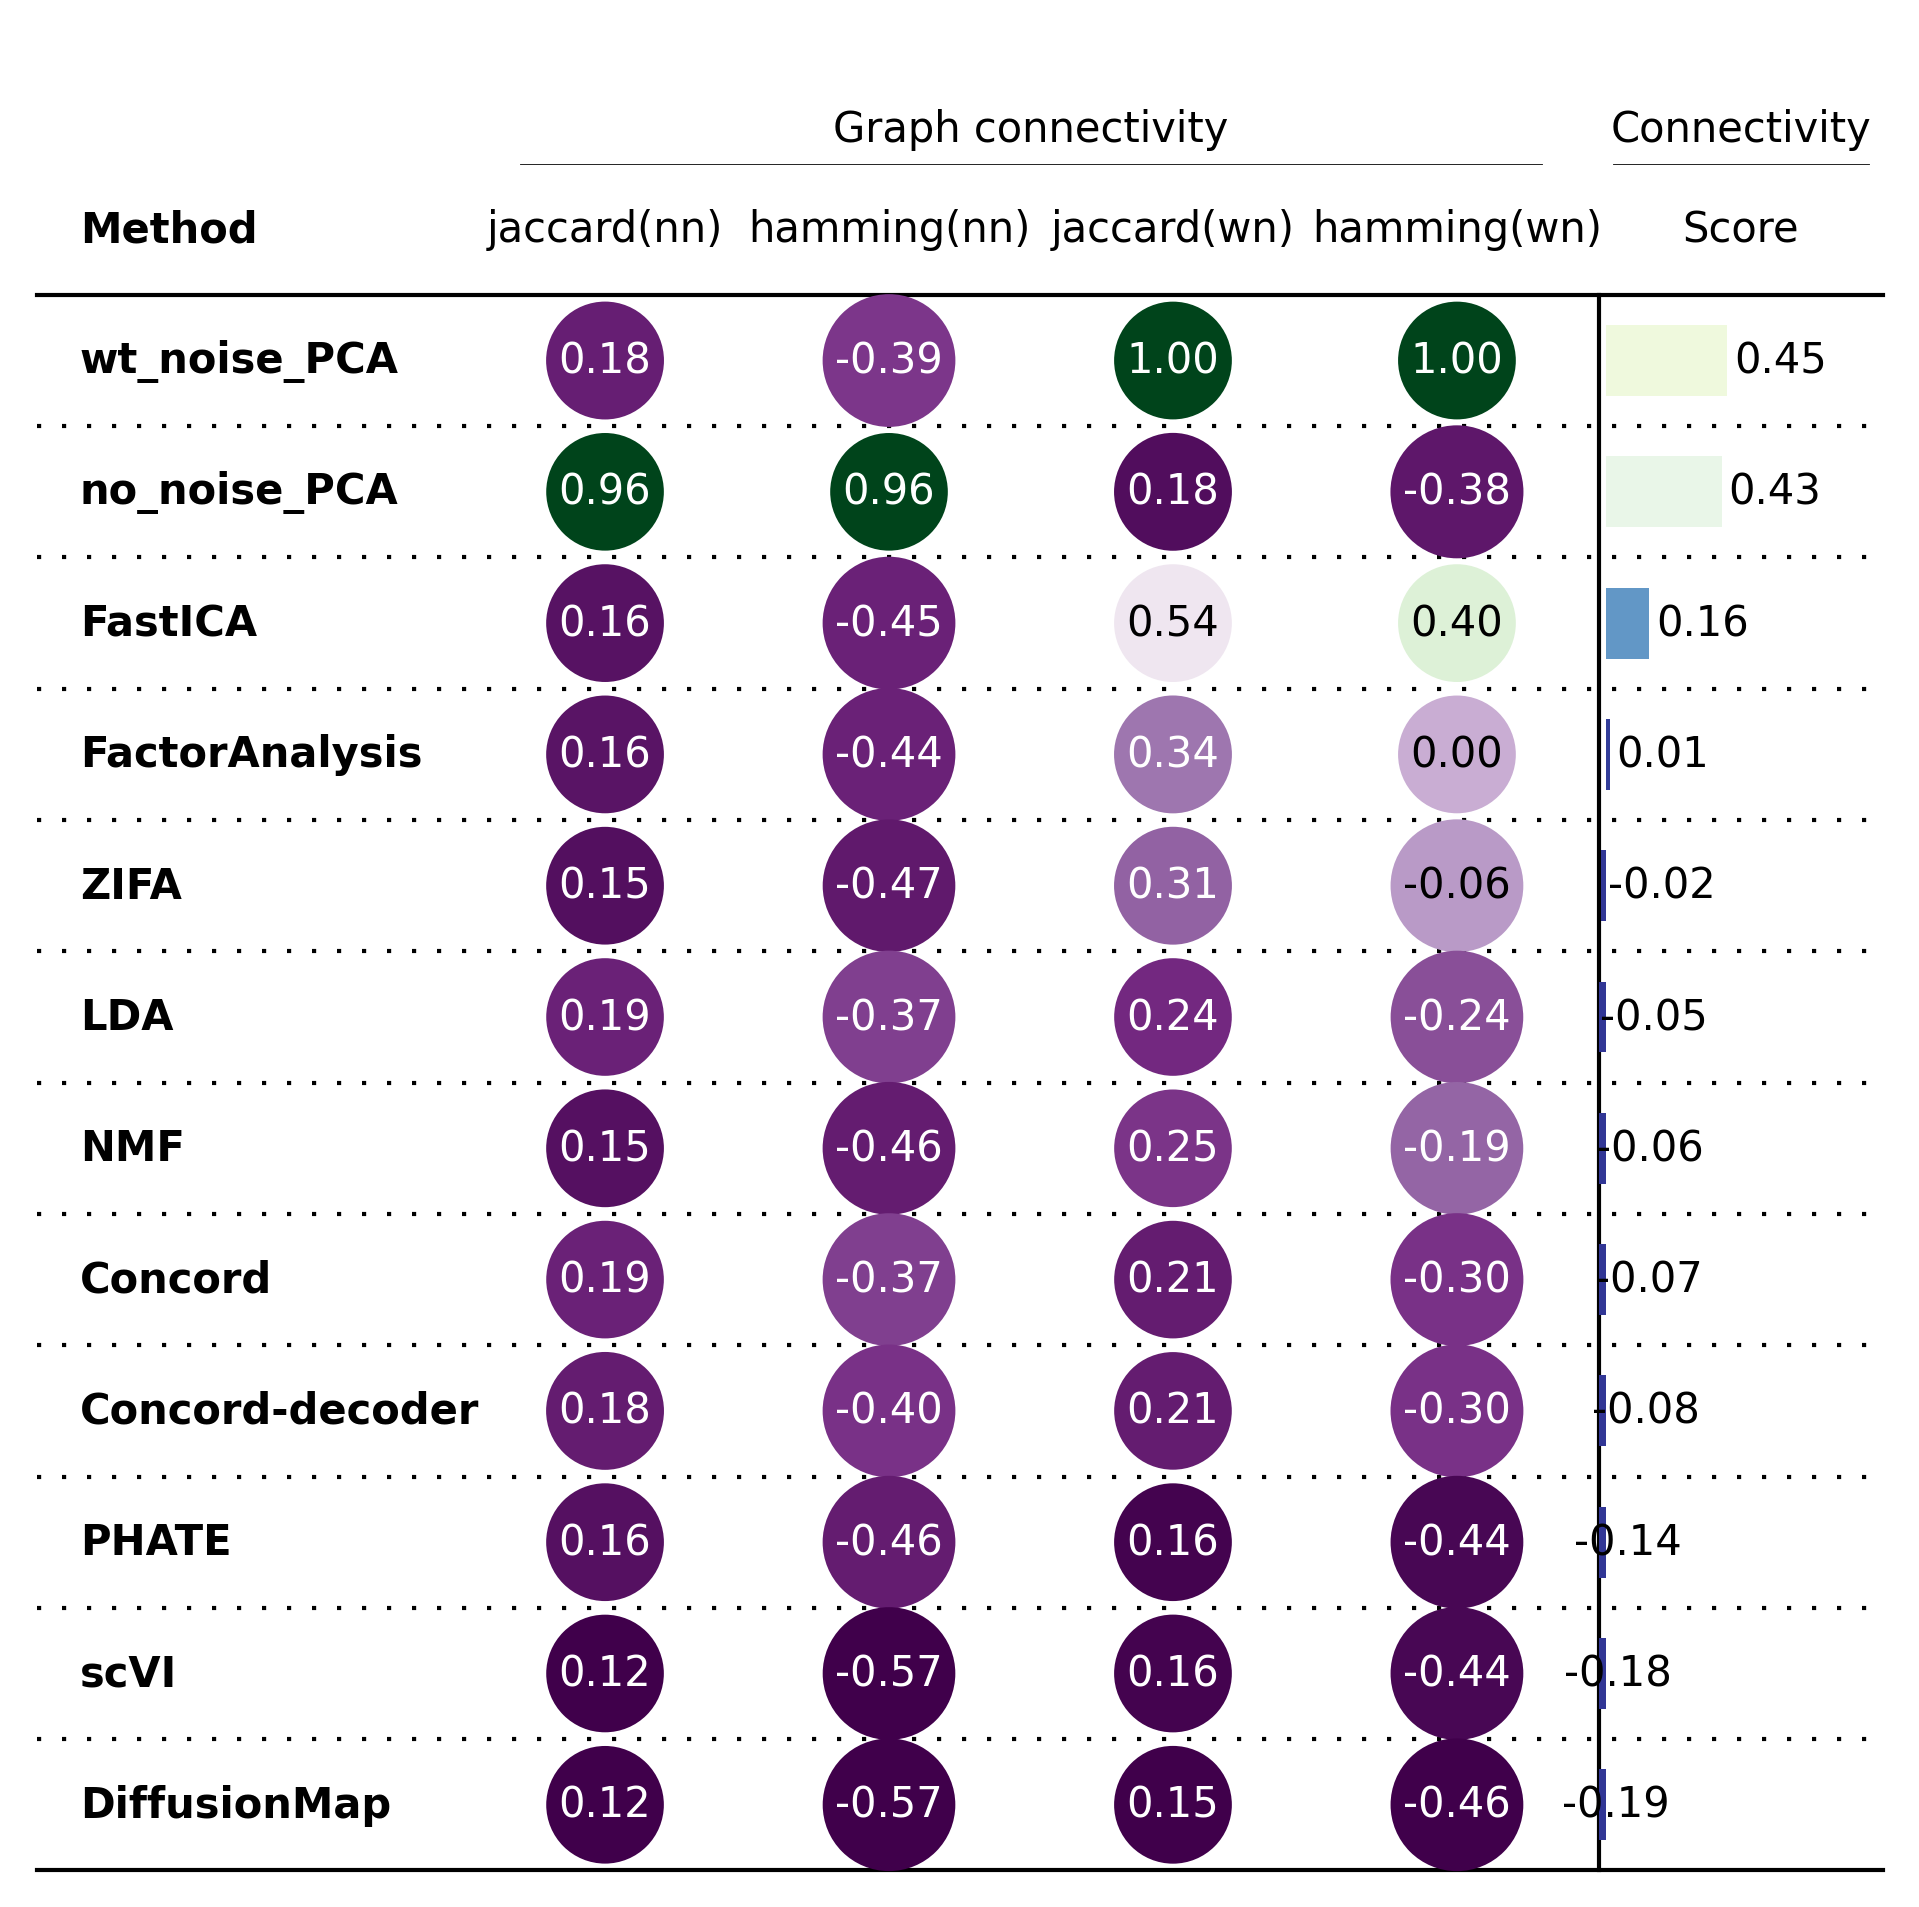

In [29]:
# compare connectivity for latent vs ground truth, store the result in a pandas dataframe
groundtruth_keys = {'(nn)': 'no_noise_PCA','(wn)': 'wt_noise_PCA'}
connectivity_df = ccd.ul.benchmark_graph_connectivity(adata, emb_keys=combined_keys, groundtruth_keys=groundtruth_keys, k=30)
agg_name1 = 'Connectivity'
agg_name2 = 'Score'
connectivity_scores = ccd.ul.benchmark_stats_to_score(connectivity_df, min_max_scale=False, one_minus=False, aggregate_score=True, aggregate_score_name1=agg_name1, aggregate_score_name2=agg_name2, rank=True, rank_col=(agg_name1,agg_name2), name_exact=False)
ccd.pl.plot_benchmark_table(connectivity_scores, pal='PRGn', pal_agg='RdYlBu_r', cmap_method = 'minmax', agg_name = agg_name1, save_path=save_dir / f"connectivity_results_{file_suffix}.pdf", figsize=(8, 8), dpi=300)


# Geomtric Features 

### Integrated benchmark pipeline

In [42]:
geometry_metrics = ['cell_distance_corr', 'local_distal_corr', 'trustworthiness', 'state_distance_corr', 'state_dispersion_corr']
dist_metric = 'cosine'
corr_types = ['pearsonr', 'spearmanr', 'kendalltau']
groundtruth_key = 'wt_noise_PCA'
groundtruth_key = 'no_noise_PCA'
# Convert state_dispersion to a dict of groundtruth dispersion
#groundtruth_dispersion = {'cluster_' + str(i): state_dispersion[i]**2 for i in range(5)} # convert to variance
geometry_df, geometry_full = ccd.ul.benchmark_geometry(adata, keys=combined_keys, eval_metrics=geometry_metrics, 
                                      dist_metric=dist_metric,
                                      corr_types = corr_types,
                                      groundtruth_key = groundtruth_key,
                                      state_key = leiden_key,
                                      batch_key = batch_key,
                                      #groundtruth_dispersion = groundtruth_dispersion,
                                      dispersion_metric='var',
                                      return_type='full',
                                      start_point=0,
                                      end_point=adata.n_obs-1,
                                      pseudotime_k = 30,
                                      truetime_key = 'time',
                                      save_dir=save_dir, 
                                      file_suffix=file_suffix)

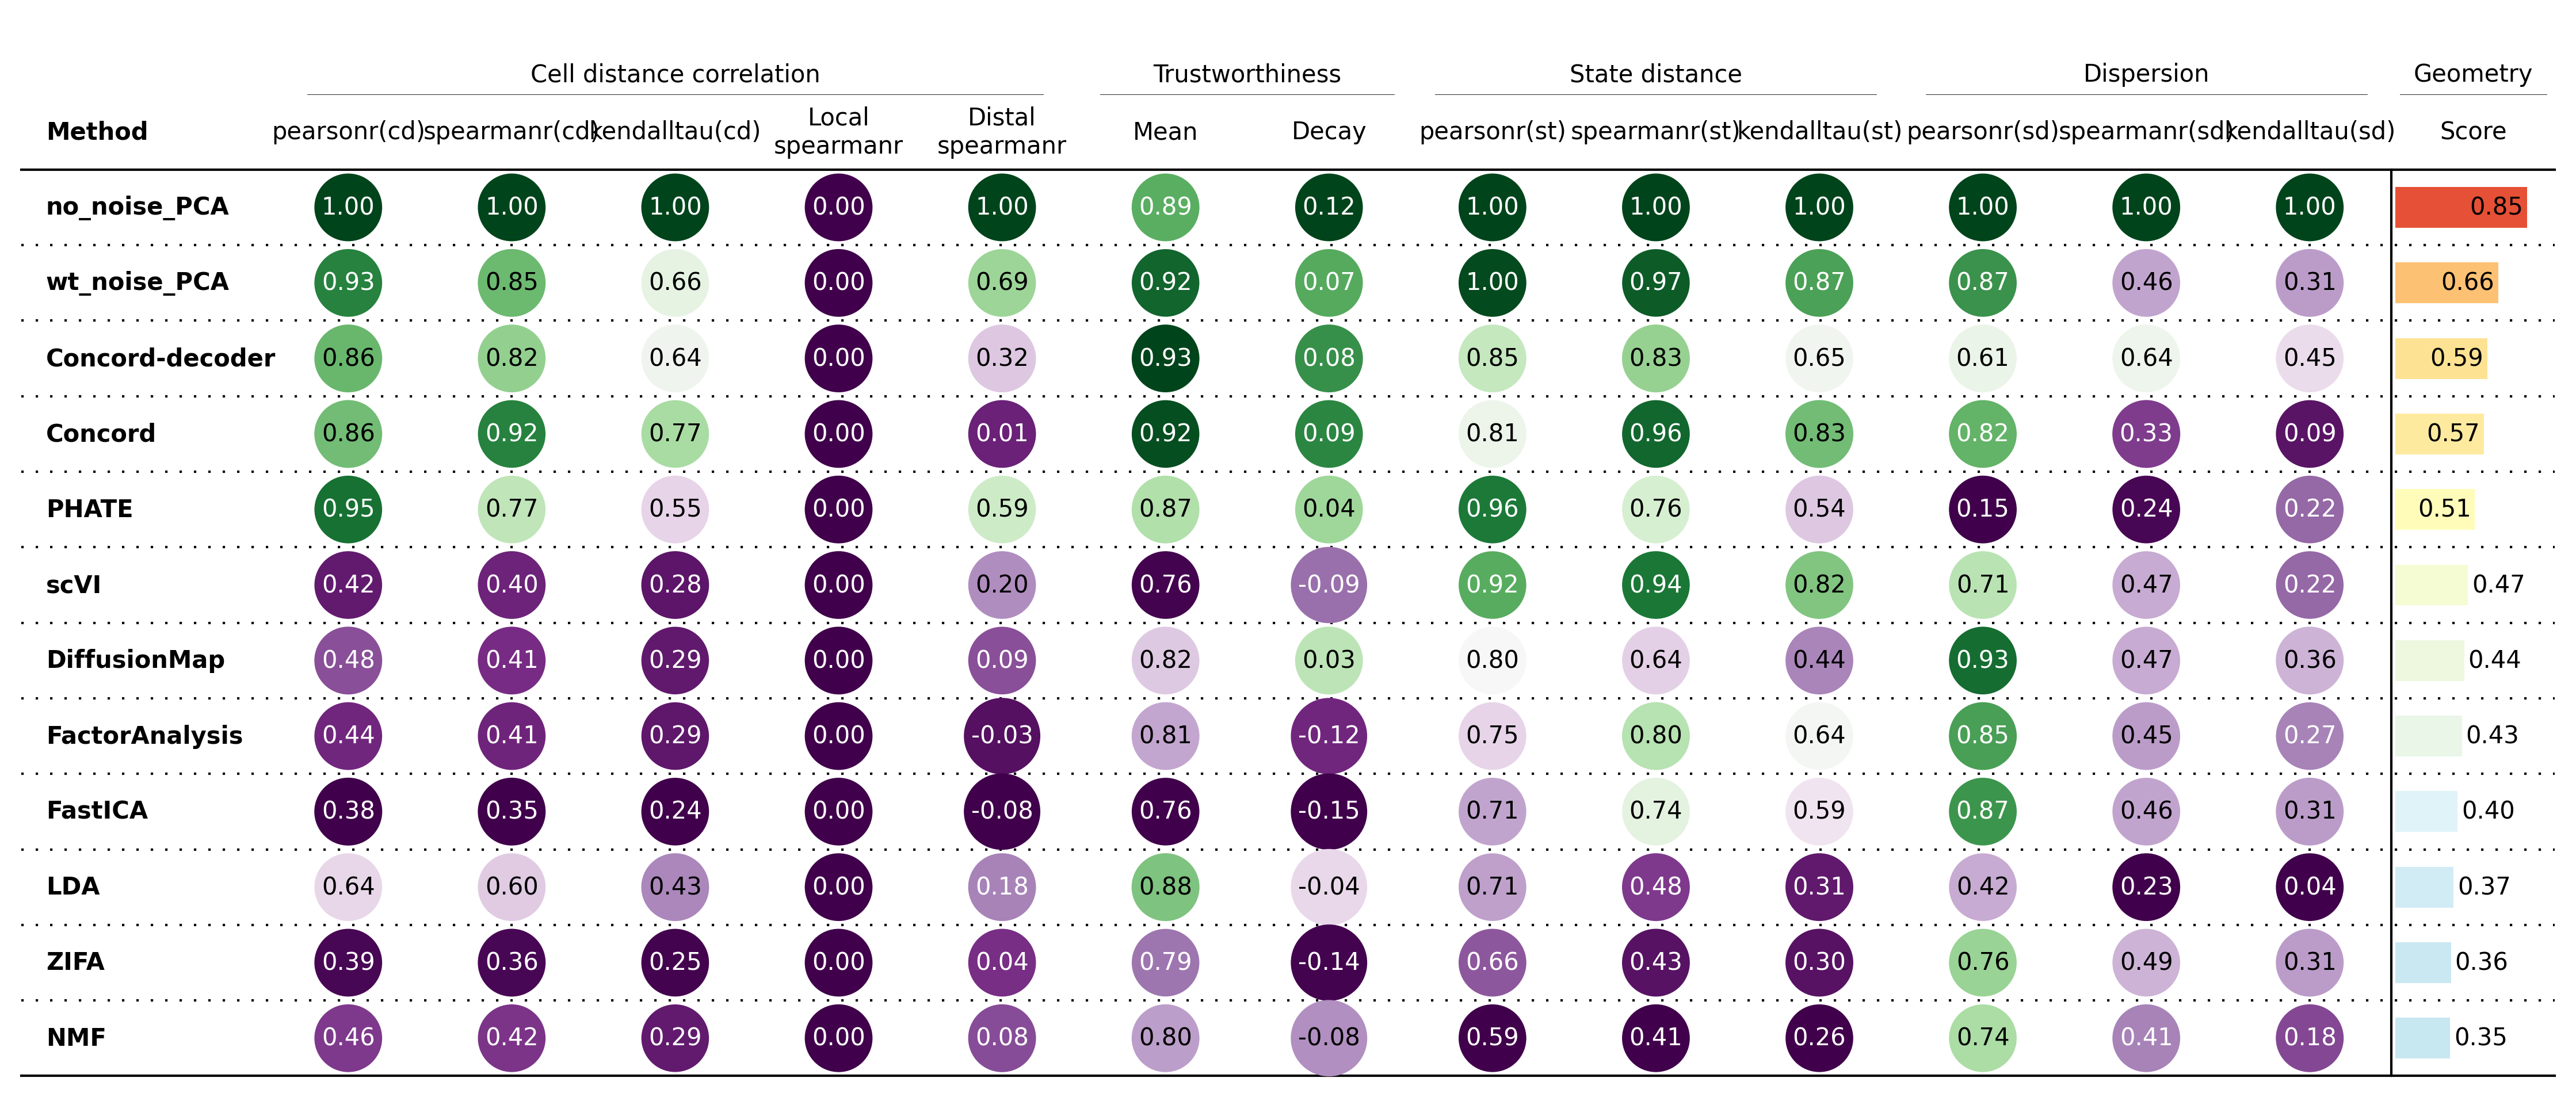

In [43]:
agg_name1 = 'Geometry'
agg_name2 = 'Score'
geometry_scores = ccd.ul.benchmark_stats_to_score(
    geometry_df, fillna = 0,               
    min_max_scale=False, one_minus=False, aggregate_score=True, aggregate_score_name1=agg_name1, aggregate_score_name2=agg_name2, rank=True, rank_col=(agg_name1,agg_name2))
ccd.pl.plot_benchmark_table(geometry_scores, pal='PRGn', pal_agg='RdYlBu_r', cmap_method = 'minmax', agg_name = agg_name1, save_path=save_dir / f"geometry_results_noscale_{dist_metric}_{groundtruth_key}_{file_suffix}.pdf", figsize=(19, 8), dpi=300)

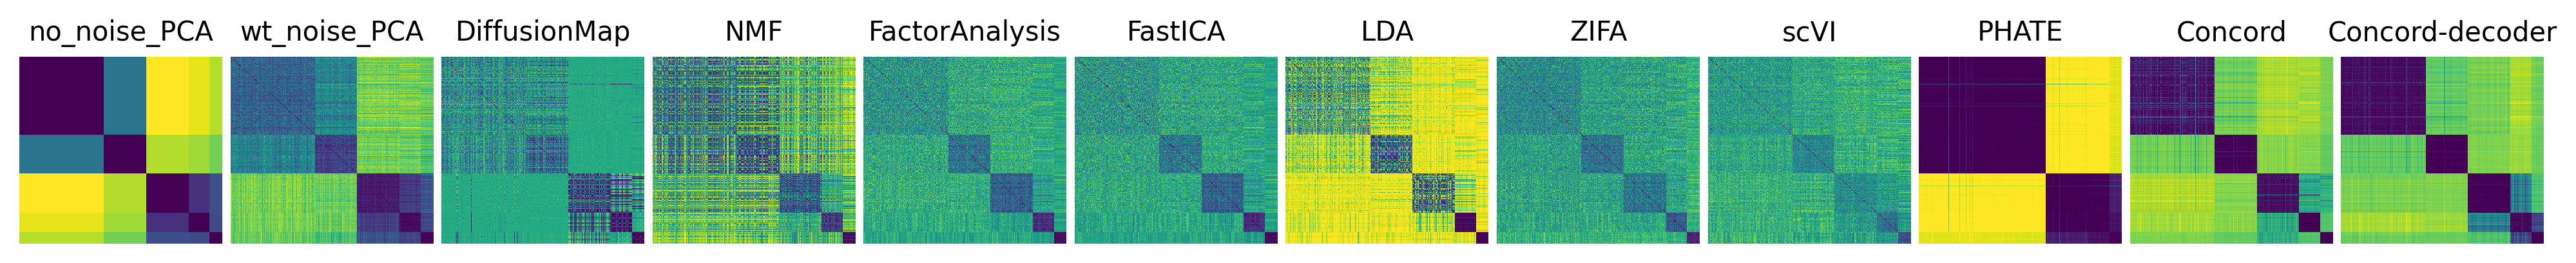

In [44]:
ccd.pl.plot_distance_heatmap(geometry_full['cell_distance_corr']['distance'], n_cols = 12, figsize=(1.1,1.3), cbar=False, dpi=300, save_path=save_dir / f"cell_distance_hmap_{file_suffix}.svg")

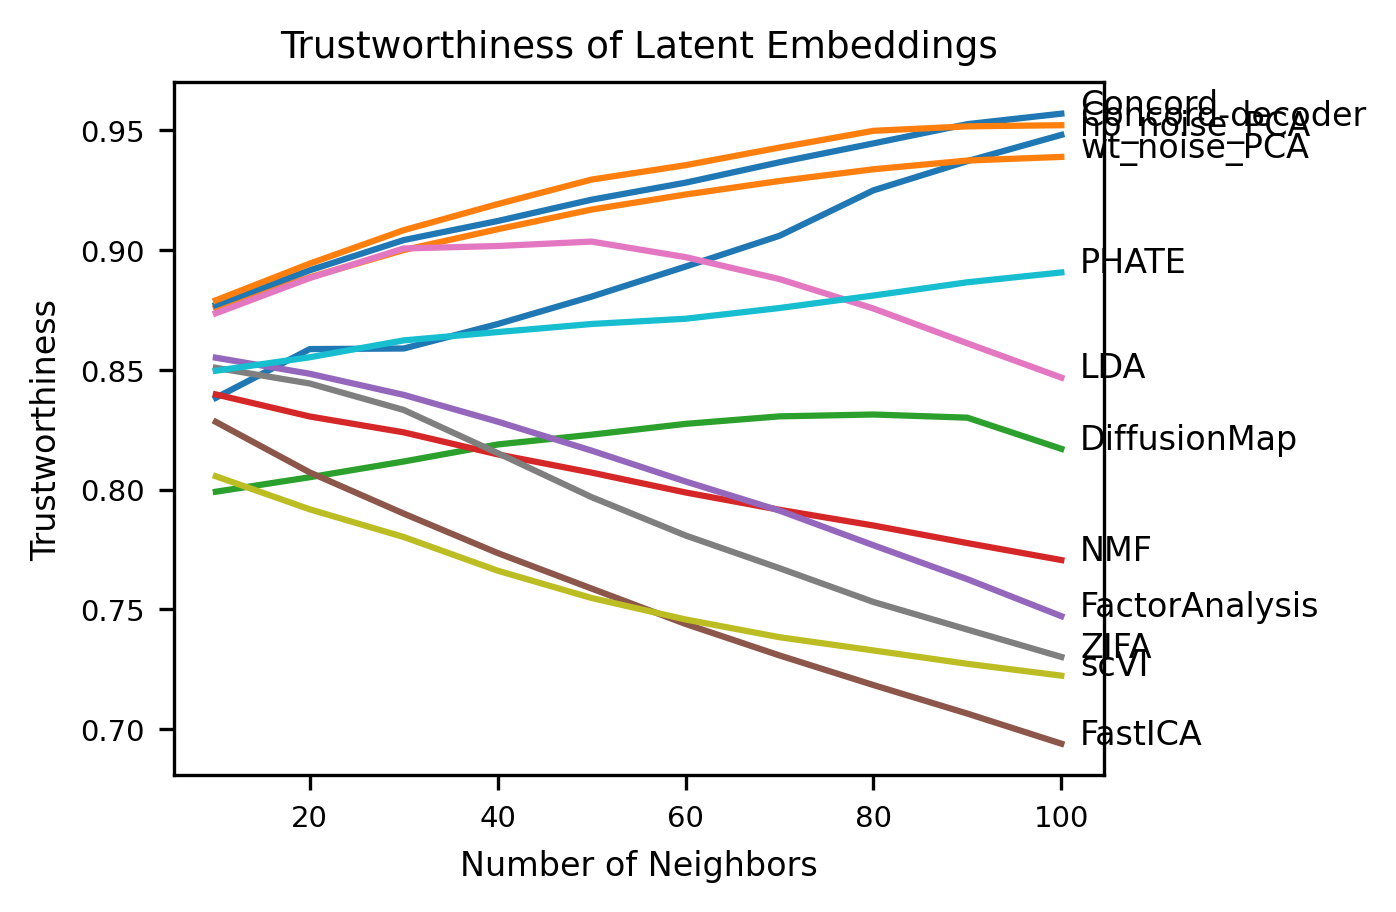

In [47]:
trustworthiness_scores = geometry_full['trustworthiness']['scores']
ccd.pl.plot_trustworthiness(trustworthiness_scores, text_shift=2, legend=False, save_path=save_dir / f"trustworthiness_{groundtruth_key}_{file_suffix}.pdf", figsize=(4,3))

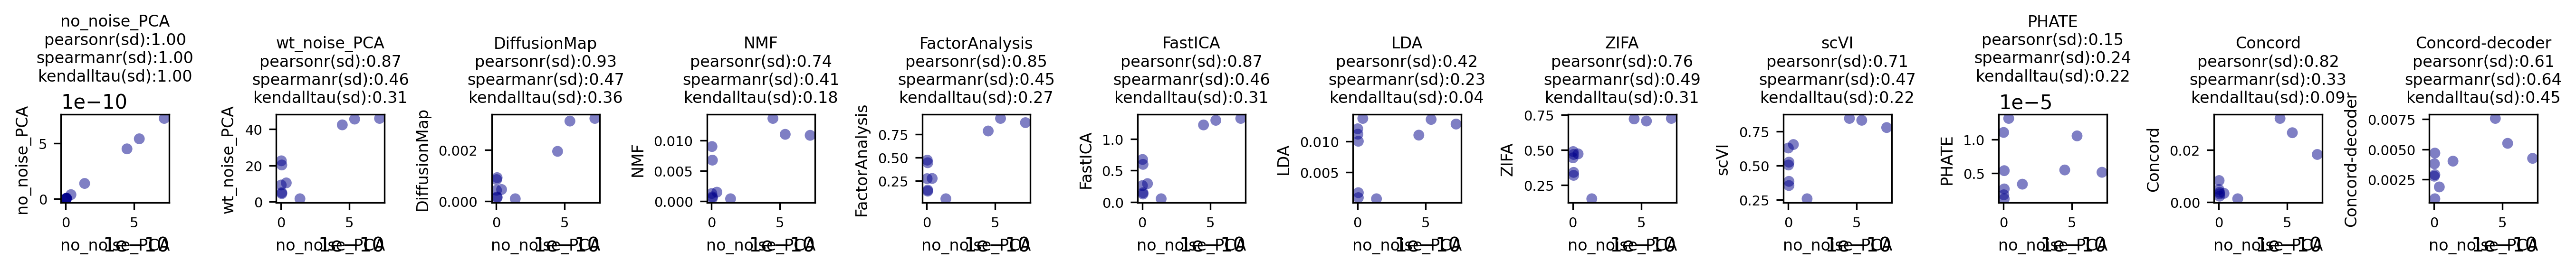

In [48]:
ccd.pl.plot_geometry_scatter(
    data_dict = geometry_full['state_dispersion_corr']['dispersion'], 
    correlation= geometry_full['state_dispersion_corr']['correlation'],
    s=30, c='darkblue',
    ground_key = groundtruth_key,
    n_cols = 12, figsize=(1.5,2.0), dpi=300, save_path=save_dir / f"state_dispersion_scatter_{groundtruth_key}_{file_suffix}.pdf")